<a href="https://colab.research.google.com/github/williambiondi/leaves_similarity/blob/main/leaves_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leaves Similarity
The goal of this project is to build a detector of similarity between the pairs of a dataset containing images that portraits single leaves, here we're using locality sensitive hashing to find similarities over the pair's feature vectors obtained, then use the given labels to verify  similarities

##0) Data gathering and resizing
In this section we'll proceed to download the dataset and resize the images (skip if you already have the resized dataset)

In [6]:
!pip install os
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [7]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=0c1d0428ec85301aa8b629cc7e47438be7eb4c9a106fe3e356a3b4e73d86c957
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Insert kaggle keys
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification --unzip

In [ ]:
#remove unlabeled and diseased leaves
! cd Plants_2/
img_path_list = [
  os.path.join(dirname, filename)
  for dirname, _, filenames in os.walk(".")
  for filename in filenames
  if ".JPG" in filename and "predict" not in dirname and "diseased" not in dirname
]

In [ ]:
#!pip install opencv-contrib-python
import numpy as np
import cv2
def resizer(filepath):
  scale_pct = 8
  img = cv2.imread(filepath)
  width = int(img.shape[1] * scale_pct/100)
  height = int(img.shape[0] * scale_pct/100)
  resized = cv2.resize(img,(width,height))
  path = os.path.join("resized",filepath.split("/")[-2])
  if(not os.path.isdir(path)):
    os.mkdir(path)
  cv2.imwrite(os.path.join(path,filepath.split("/")[-1]), resized)


In [ ]:
os.mkdir("resized")
for image in img_path_list:
  resizer(image)

In [8]:
#uncomment to load dataset quickly from drive profile: no need to if all the cells above were executed
#from google.colab import drive
#drive.mount('/content/gdrive/', force_remount=True)
#!unzip -q /content/gdrive/MyDrive/resized_leaves.zip

Mounted at /content/gdrive/


##1) Data preprocessing
From the resulting resized dataset we will prepare the resilent distributed dataset that will be used to perform feature extraction and LSH and a dataframe with image name and its associated label that we will use to verify similarities

In [9]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from typing import List, Tuple
import math
from itertools import combinations

In [25]:
#remove unlabeled leaves
img_paths = [
    os.path.join(dirname, filename)
    for dirname, _, filenames in os.walk(".")
    for filename in filenames
    if ".JPG" in filename and "Plants_2" not in dirname
]
#get plant labels
plant_name = [path.split("/")[2].split("healthy ")[0].strip() for path in img_paths]

In [26]:
df = pd.DataFrame({"file":img_paths,"label":plant_name})

<ipython-input-27-e82d656bddc7>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  class_dist.set_xticklabels(class_dist.get_xticklabels(), rotation=90)


[Text(0, 0, 'Jamun'),
 Text(1, 0, 'Alstonia Scholaris'),
 Text(2, 0, 'Basil'),
 Text(3, 0, 'Pongamia Pinnata'),
 Text(4, 0, 'Mango'),
 Text(5, 0, 'Chinar'),
 Text(6, 0, 'Arjun'),
 Text(7, 0, 'Jatropha'),
 Text(8, 0, 'Gauva'),
 Text(9, 0, 'Pomegranate'),
 Text(10, 0, 'Lemon')]

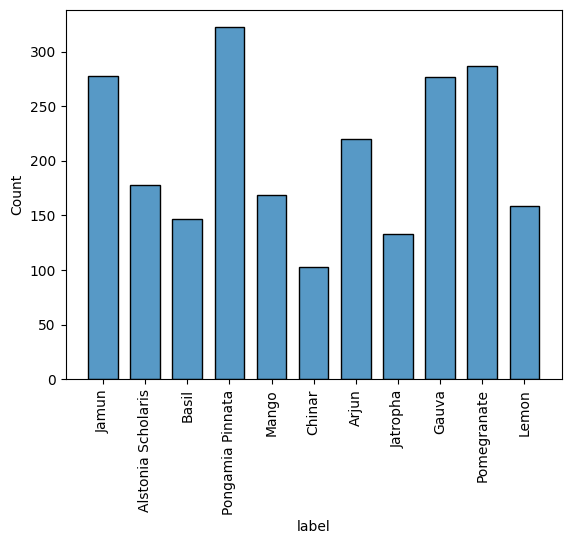

In [27]:
class_dist = sns.histplot(df, x="label", shrink = 0.7)
class_dist.set_xticklabels(class_dist.get_xticklabels(), rotation=90)

In [28]:
#build spark session
spark = SparkSession.builder.appName("LeavesSimilarity").master("local[*]").getOrCreate()
sc = spark.sparkContext


In [29]:
#create an rdd with paths of images
leaves_path_rdd = sc.parallelize(img_paths)

##2)Feature Extraction
For each image in our RDD we'll perform ORB (Oriented FAST and Rotated BRIEF) , it is a feature detection and description algorithm commonly used in computer vision tasks such as object recognition, image stitching, and visual tracking. We'll obtain keypoints for the features and a correspondent descriptor

In [30]:
def feature_extractor(filepath: str)-> List[Tuple[Tuple[float, float], np.ndarray]]:
  img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
  #initialize ORB
  orb = cv2.ORB_create()
  #detect keypoints and descriptors
  keypoints, descriptors = orb.detectAndCompute(img, None)
  rdd_element = []
  for item in zip(keypoints,descriptors):
    keypoint = item[0]
    descriptor = item[1]
    #converting the keypoint as a tuple since the original object is not serializable
    image_keypoint = (
            (
              keypoint.pt,
              keypoint.size,
              keypoint.angle,
              keypoint.response,
              keypoint.octave,
              keypoint.class_id,
            ),
            descriptor,
        )
    rdd_element.append(image_keypoint)
  return rdd_element

In [31]:
def get_plant_type(filename):
  return filename.split("/")[2].split("healthy")[0].strip()

In [32]:
#map filepaths to feature vectors
features_rdd = leaves_path_rdd.map(lambda file: (feature_extractor(file), file, get_plant_type(file)))

##3) Generate Hash functions
In this section we'll proceed to generate hash function that will be used to obtain the signature matrix of the descriptors for each image in the rdd: starting from finding the highest value that the list of desriptors can assume we generate a given number of hash functions with this pattern


```
(a * x + b) % max_element_value
```

Where x is the input value, a and b are both random numbers between 1 and max_element_value


In [33]:
def find_max_descriptor_value(rdd_element):
  # we ignore the filepath since we want to find the highest element value in the features
  feature_vector, _ , _ = rdd_element
  max_value = 0
  #we ignore keypoints
  for _, descriptor in feature_vector:
    internal_max = np.max(descriptor)
    if internal_max > max_value:
      max_value = internal_max
  return max_value

In [34]:
max_element_values_rdd = features_rdd.map(find_max_descriptor_value)

In [35]:
max_element_value = max_element_values_rdd.reduce(max)

In [36]:
def generate_hash_functions(num_hash_functions, max_element_value):
  # Generate a set of hash functions
  hash_functions = []
  for _ in range(num_hash_functions):
    a = np.random.randint(1, max_element_value)
    b = np.random.randint(1, max_element_value)
    hash_functions.append(lambda x: np.mod(a * x + b, max_element_value))
  return hash_functions

In [37]:
#we set hash functions and bands
num_hash_functions = 170
num_bands = 170
band_size = int(len(img_paths)/num_hash_functions)

In [38]:
#compute the threshold for the banding parameters
threshold = (1/num_bands)**(1/band_size)
print(threshold)

0.6736386642807495


In [39]:
hash_functions = generate_hash_functions(num_hash_functions,max_element_value)

##4)Signature Matrix
In this section we'll compose our signature matrix, first we're going to apply our hash functions to all the image's descriptors, then we'll fill in the matrix with the unique signatures present in the whole rdd to save space and insert the image signatures for each row

In [40]:
def compute_signature(element, hash_functions):
  (keypoints, filepath, label) = element
  signature = []
  num_hash_functions = len(hash_functions)
  for j,(keypoint,descriptor) in enumerate(keypoints):
    #we take the descriptors array inside the keypoint tuple
    hash_values = hash_functions[j % num_hash_functions](descriptor)
    signature.append(np.min(hash_values))
  return (signature, filepath, label)

In [41]:
signatures_rdd = features_rdd.map(lambda x: compute_signature(x,hash_functions))

In [42]:
def explode_list(signatures):
  for k in signatures:
    yield k

In [43]:
unique_signatures = signatures_rdd.flatMap(lambda x:explode_list(x[0])).distinct().collect()

In [44]:
def fill_signature_matrix(data_tuple, unique_signatures):
  hash_signatures, file_path, label = data_tuple

  num_signatures = len(unique_signatures)
  signature_vector = np.zeros(num_signatures, dtype=int)
  #searchsorted method goes out of bounds so we use this isin instead
  indices = np.where(np.isin(unique_signatures, hash_signatures))[0]
  signature_vector[indices] = 1

  return file_path, label, signature_vector

In [45]:
signature_matrix_rdd = signatures_rdd.map(lambda x: fill_signature_matrix(x, unique_signatures))

In [46]:
signature_matrix_rdd.take(1)

[('./resized/Jamun healthy (P5a)/0005_0131.JPG',
  'Jamun',
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]

In [47]:
def bands(rdd_element, band_size, n_bands):
  result = []
  for i in range(num_bands):
    subsequence = (rdd_element[0], rdd_element[1], rdd_element[2][i * band_size: (i + 1) * band_size])
    result.append((i, subsequence))
  return result

In [48]:
bands_rdd = signature_matrix_rdd.flatMap(lambda x: bands(x, num_bands, band_size)).groupByKey()

## 5) Candidate Pairs
We generate the candidate pairs among the bands in the signature matrix and compute jaccard similarity between signature vectors

In [49]:
def jaccard_similarity(signvec_a,signvec_b):
  intersection = sum(a == b == 1 for a, b in zip(signvec_a, signvec_b))
  union = sum(a == 1 or b == 1 for a, b in zip(signvec_a, signvec_b))
  if union != 0:
    return intersection/union
  else:
    return 0

In [50]:
def candidate_pairs(band, threshold):
  pairs = []
  for subseq1, subseq2 in combinations(band,2):
    similarity = jaccard_similarity(subseq1[2], subseq2[2])
    if similarity > threshold:
      pairs.append((subseq1[0],subseq1[1],subseq2[0],subseq2[1], similarity))
  return pairs

In [51]:
def candidate_pairs_within_plant(band, threshold):
  pairs = []
  for subseq1, subseq2 in combinations(band,2):
    if subseq1[1] == subseq2[1]:
      similarity = jaccard_similarity(subseq1[2], subseq2[2])
    else:
      continue
    if similarity > threshold:
      pairs.append((subseq1[1], (subseq1[0],subseq2[0], similarity)))
  return pairs

In [52]:
candidate_pairs_rdd = bands_rdd.flatMap(lambda x: candidate_pairs(list(x[1]),0.4))

In [53]:
plant_type_rdd = bands_rdd.flatMap(lambda x: candidate_pairs_within_plant(list(x[1]),0.1))

In [74]:
plant_type_rdd.take(1)

[('Pongamia Pinnata',
  ('./resized/Pongamia Pinnata healthy (P7a)/0007_0024.JPG',
   './resized/Pongamia Pinnata healthy (P7a)/0007_0194.JPG',
   0.5882352941176471))]

##6)Results


In [66]:
def show_pair_sim(sample_pair):
  image_a = cv2.imread(sample_pair[0])
  image_b = cv2.imread(sample_pair[2])
  similarity = str(round(sample_pair[4] * 100,2))+"%"
  #dimensions of the resulting image
  height1, width1, _ = image_a.shape
  height2, width2, _ = image_b.shape

  gap_size = 100  #size of the white gap

  combined_width = width1 + gap_size + width2
  combined_height = height1

  #blank white image with the desired dimensions
  combined_image = np.ones((combined_height, combined_width, 3), dtype=np.uint8) * 255

  #first image to the left side of the combined image
  combined_image[:height1, :width1] = image_a

  #second image to the right side of the combined image, leaving a white gap in between
  combined_image[:height2, width1+gap_size:] = image_b
  filename_a = sample_pair[0].split("resized/")[1]
  filename_b = sample_pair[2].split("resized/")[1]
  #show pairs
  plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  result = "Similarity of "+filename_a+" - "+filename_b+":"+similarity
  plt.text(combined_width // 2, combined_height + 50, result, ha='center', fontsize=10)
  plt.show()

In [63]:
sample_pair_diss = candidate_pairs_rdd.filter(lambda x: x[4] < 0.5).take(1)[0]

In [64]:
sample_pair_diss

('./resized/Jamun healthy (P5a)/0005_0131.JPG',
 'Jamun',
 './resized/Jamun healthy (P5a)/0005_0233.JPG',
 'Jamun',
 0.43333333333333335)

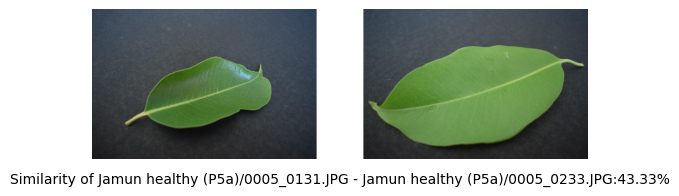

In [67]:
show_pair_sim(sample_pair_diss)

In [39]:
sample_pair_sim = candidate_pairs_rdd.filter(lambda x : x[4]>0.7).take(1)[0]

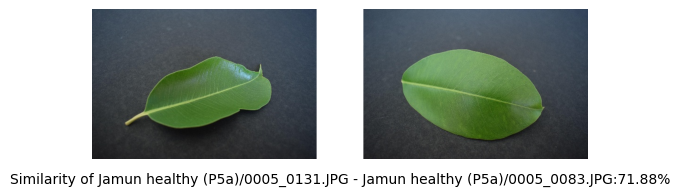

In [40]:
show_pair_sim(sample_pair_sim)

In [54]:
def draw_heatmap(sim_list, plant_name):
  n_images = math.ceil(np.sqrt(len(sim_list)))
  similarity_matrix = np.zeros((n_images, n_images))
  for i, sim in enumerate(sim_list):
    row = i // n_images
    col = i % n_images
    similarity_matrix[row, col] = sim
    similarity_matrix[col, row] = sim
  plt.figure()
  sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False)
  plt.title(plant_name+' Similarity Heatmap')
  plt.show()

overall heatmap

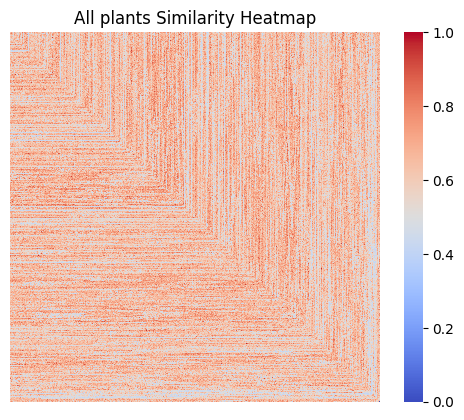

In [68]:
similarities_all = candidate_pairs_rdd.map(lambda x: x[4]).collect()
draw_heatmap(similarities_all, "All plants")

In [69]:
def prepare_ground_truth(pair, threshold):
  _, label_a, _, label_b, similarity = pair
  ground_truth = 1 if label_a == label_b else 0
  prediction = 1 if similarity >= threshold else 0
  return (ground_truth, prediction)

In [72]:
pred_true = candidate_pairs_rdd.map(lambda x:prepare_ground_truth(x, threshold))

overall metrics

In [74]:
#set up 1 accumulator to test similarity and same type test, then the other two accumulators are used to sum intermediate results
tp_fp_fn = pred_true.aggregate((0,0,0),
                               lambda acc, x: (acc[0] + int(x[0] == 1 and x[1] == 1),
                                               acc[1] + int(x[0] == 0 and x[1] == 1),
                                               acc[2] + int(x[0] == 1 and x[1] == 0)),
                               lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1], acc1[2] + acc2[2]))

In [75]:
tp, fp, fn = tp_fp_fn
precision = tp / (tp + fp)
recall = tp /(tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

In [79]:
result = "Precision:"+str(round(precision*100,2))+"% \nRecall:"+str(round(recall*100,2))+"% \nF1-score:"+str(round(f1,2))
print(result)

Precision:11.02% 
Recall:37.12% 
F1-score:0.17


Results within plant types

In [55]:
names = list(set(plant_name))

In [56]:
plant_groups_rdd = plant_type_rdd.groupByKey()

Assumed that in the similarities vector all the images belong to the same type of plant, we calculate metrics based on the threshold established above and we draw respective heatmaps between pairs that belong to the same plant type


In [60]:
def metrics(similarities, threshold):
  pred = [1 if x > threshold else 0 for x in similarities ]
  _, counts = np.unique(pred, return_counts = True)
  fn,tp = counts
  #no false positives so precision is 1
  precision = 1
  recall = (tp/(tp+fn))
  f1 = 2 * (precision * recall) / (precision + recall)
  result = "Recall:"+str(round(recall*100,2))+"% F1-score:"+str(round(f1,2))
  return result

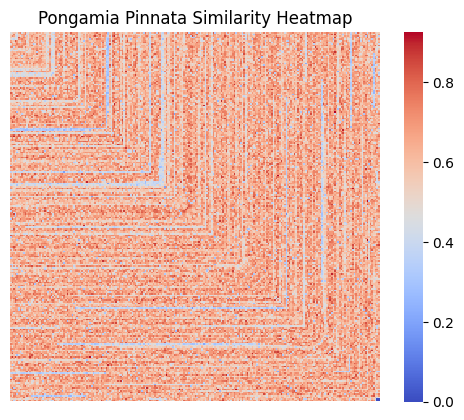

Pongamia Pinnata:
Recall:31.26% F1-score:0.48


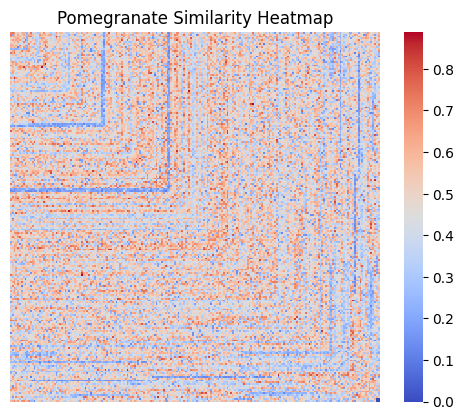

Pomegranate:
Recall:5.11% F1-score:0.1


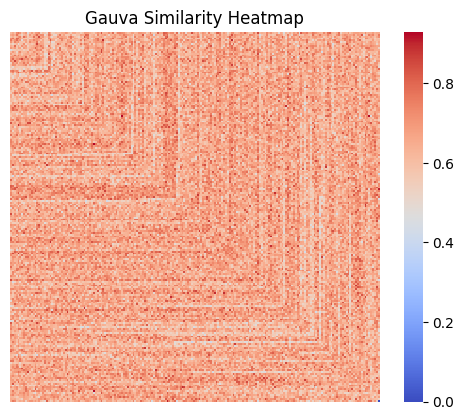

Gauva:
Recall:40.63% F1-score:0.58


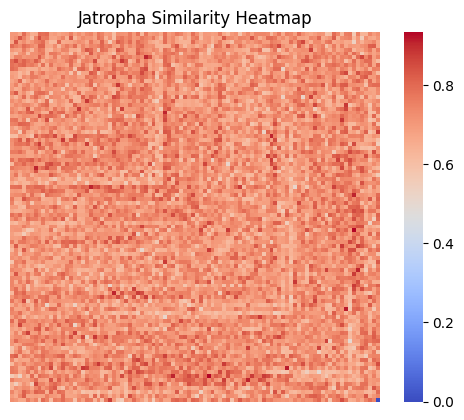

Jatropha:
Recall:77.93% F1-score:0.88


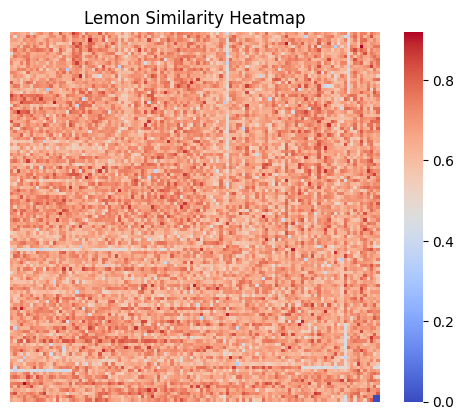

Lemon:
Recall:49.82% F1-score:0.67


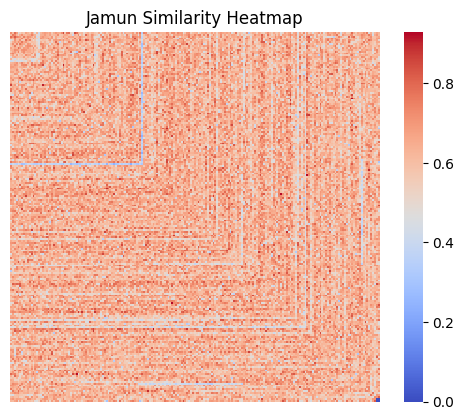

Jamun:
Recall:30.0% F1-score:0.46


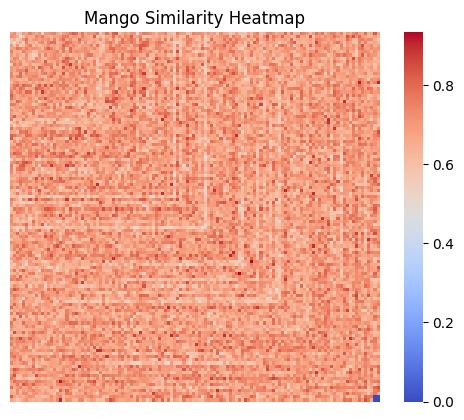

Mango:
Recall:59.14% F1-score:0.74


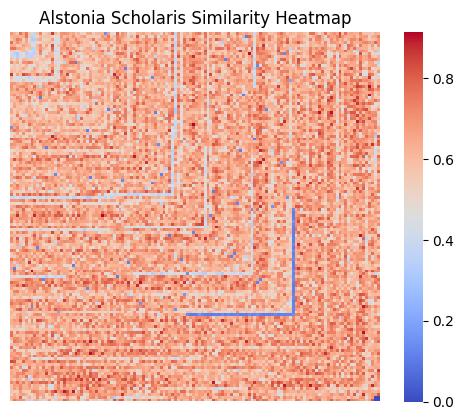

Alstonia Scholaris:
Recall:32.65% F1-score:0.49


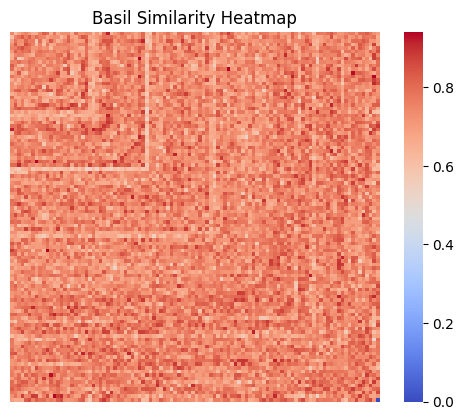

Basil:
Recall:85.7% F1-score:0.92


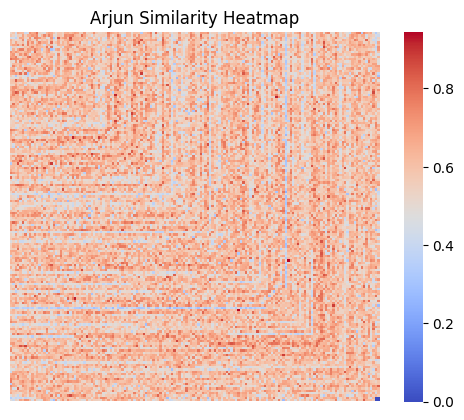

Arjun:
Recall:19.7% F1-score:0.33


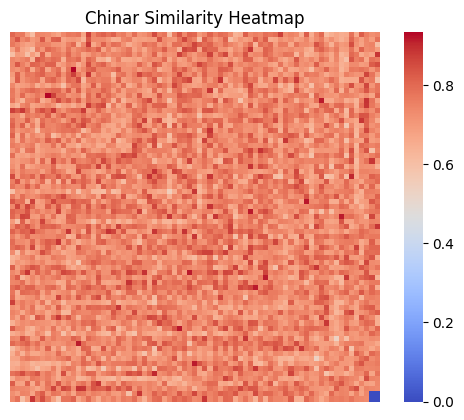

Chinar:
Recall:87.74% F1-score:0.93


In [62]:
for plant in names:
  plant_group = plant_groups_rdd.filter(lambda x: x[0] == plant).first()
  similarities = [x[2] for x in list(plant_group[1])]
  draw_heatmap(similarities,plant)
  print(plant+":\n"+metrics(similarities, threshold))